In [43]:
import anndata
import numpy as np
import pandas as pd
import plotnine as p
import matplotlib.pyplot as plt
import scvi
from scvi.model.utils import mde
import scHPL
import torch

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [164]:
adata = anndata.read_h5ad('imyoo_capillary_blood_samples_76535_pbmcs.h5ad')
adata

AnnData object with n_obs × n_vars = 87213 × 36601
    obs: 'barcode', 'Sample IDs', 'Participant IDs', 'Cell Barcoding Runs', 'cell_type_level_1', 'cell_type_level_2', 'cell_type_level_3', 'cell_type_level_4'
    var: 'name', 'id'

In [3]:
(
    adata
    .obs
    .groupby(
        ['Cell Barcoding Runs', 'Sample IDs', 'Participant IDs'],
        observed = True
    )
    .size()
    .rename('#')
    .reset_index()
)

Cell Barcoding Runs  Sample IDs  Participant IDs     #
0                    28          20                2  1148
1                    40          95                3  4575
2                    40         424                2  4450
3                    41         329               51  7126
4                    62         892                3  2605
5                    62         894                2  1659
6                    62         909                2   924
7                    62         911                3  1154
8                    62         952                2  1415
9                    62         953                3  2401
10                   62         958                2  1392
11                   62         959                3  1805
12                   62         970                2  3590
13                   62         971                3  3827
14                   62         977                2  1677
15                   62         978                3  2032
16                   62        1004                3  4612
17                   62        1005                2  2374
18                   62        1071                2  2689
19                   62        1072                3  3342
20                   62        1170                2  4977
21                   62        1171                3  5178
22                   62        1176                2  1527
23                   62        1177                3  2166
24                   77        1382                2  1560
25                   77        1385                2  1535
26                   77        1394                3  2773
27                   77        1395                3  2022
28                   79        1553                3  2330
29                   79        1585                3  2767
30                   79        1593                3  1527
31                   79        1643                3  4054

In [4]:
(
    adata
    .obs
    .groupby(
        ['cell_type_level_2', 'cell_type_level_3', 'cell_type_level_4', 'Participant IDs'],
        observed = True
    )
    .size()
    .rename('#')
    .reset_index()
)

cell_type_level_2    cell_type_level_3       cell_type_level_4   
0            T Cells          CD4 T Cells   CD4 Cytotoxic T Cells  \
1            T Cells          CD4 T Cells   CD4 Cytotoxic T Cells   
2            T Cells          CD4 T Cells   CD4 Cytotoxic T Cells   
3            T Cells          CD4 T Cells      CD4 Memory T Cells   
4            T Cells          CD4 T Cells      CD4 Memory T Cells   
5            T Cells          CD4 T Cells      CD4 Memory T Cells   
6            T Cells          CD4 T Cells       CD4 Naive T Cells   
7            T Cells          CD4 T Cells       CD4 Naive T Cells   
8            T Cells          CD4 T Cells       CD4 Naive T Cells   
9            T Cells          CD4 T Cells  CD4 Regulatory T Cells   
10           T Cells          CD4 T Cells  CD4 Regulatory T Cells   
11           T Cells          CD4 T Cells  CD4 Regulatory T Cells   
12           T Cells          CD8 T Cells   CD8 Cytotoxic T Cells   
13           T Cells          CD8 T Cells   CD8 Cytotoxic T Cells   
14           T Cells          CD8 T Cells   CD8 Cytotoxic T Cells   
15           T Cells          CD8 T Cells      CD8 Memory T Cells   
16           T Cells          CD8 T Cells      CD8 Memory T Cells   
17           T Cells          CD8 T Cells      CD8 Memory T Cells   
18           T Cells          CD8 T Cells       CD8 Naive T Cells   
19           T Cells          CD8 T Cells       CD8 Naive T Cells   
20           T Cells          CD8 T Cells       CD8 Naive T Cells   
21           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 1   
22           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 1   
23           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 1   
24           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 2   
25           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 2   
26           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 2   
27           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 3   
28           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 3   
29           T Cells  Gamma-Delta T Cells   Gamma-Delta T Cells 3   

    Participant IDs     #  
0                 2   145  
1                 3    11  
2                51     2  
3                 2  4854  
4                 3  3718  
5                51  1249  
6                 2  2391  
7                 3  7733  
8                51  1017  
9                 2  1003  
10                3  1204  
11               51   207  
12                2  1986  
13                3   162  
14               51   375  
15                2  1212  
16                3   823  
17               51   540  
18                2  1312  
19                3  3247  
20               51   979  
21                2   404  
22                3   260  
23               51   109  
24                2   111  
25                3   151  
26               51    41  
27                2   327  
28                3   393  
29               51   128

In [5]:
adata.obs['Participant IDs'].value_counts()

Participant IDs
3     49170
2     30917
51     7126
Name: count, dtype: int64

In [25]:
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key='Sample IDs',
)

model = scvi.model.SCVI(
    adata, 
    n_layers = 2,
    gene_likelihood = 'nb'
)

model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample IDs',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  32   │
│         n_cells          │ 87213 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 36601 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample IDs'] │     20     │          0          │
│                         │     95     │          1          │
│                         │    329     │          2          │
│                         │    424     │          3          │
│                         │    892     │          4          │
│                         │    894     │          5          │
│                         │    909     │          6          │
│                         │    911     │          7          │
│                         │    952     │          8          │
│                         │    953     │          9          │
│                         │    958     │         10          │
│                         │    959     │         11          │
│                         │    970     │         12          │
│                         │    971     │         13          │
│                         │    977     │         14          │
│                         │    978     │         15          │
│                         │    1004    │         16          │
│                         │    1005    │         17          │
│                         │    1071    │         18          │
│                         │    1072    │         19          │
│                         │    1170    │         20          │
│                         │    1171    │         21          │
│                         │    1176    │         22          │
│                         │    1177    │         23          │
│                         │    1382    │         24          │
│                         │    1385    │         25          │
│                         │    1394    │         26          │
│                         │    1395    │         27          │
│                         │    1553    │         28          │
│                         │    1585    │         29          │
│                         │    1593    │         30          │
│                         │    1643    │         31          │
└─────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [26]:
model.train(50, check_val_every_n_epoch = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:45<00:00, 15.51s/it, loss=7.36e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:45<00:00, 15.31s/it, loss=7.36e+03, v_num=1]


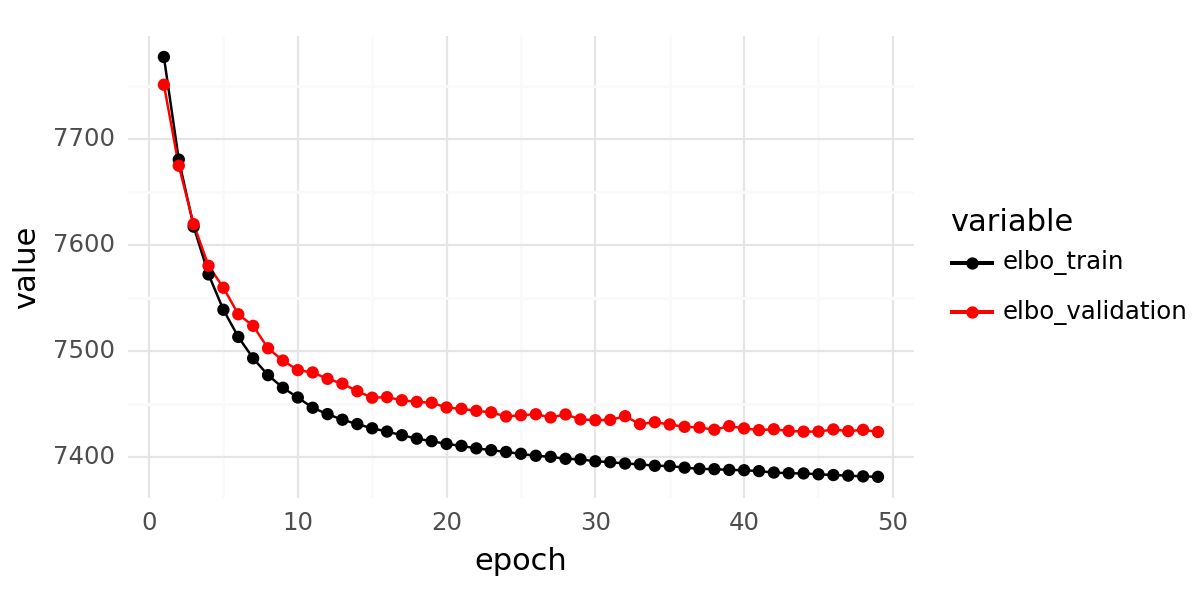

In [150]:
history_df = (
    model.history['elbo_train'].astype(float)
    .join(model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [165]:
(
    adata
    .obs
    .groupby(
        ['cell_type_level_1', 'cell_type_level_2', 'cell_type_level_3', 'cell_type_level_4'],
        observed = True,
        dropna = False
    )
    .size()
    .rename('#')
    .reset_index()
)

cell_type_level_1             cell_type_level_2   
0           Lymphoid                       B Cells  \
1           Lymphoid                       B Cells   
2           Lymphoid                       B Cells   
3           Lymphoid                       B Cells   
4           Lymphoid                       B Cells   
5           Lymphoid                       B Cells   
6           Lymphoid          Lymphoid Progenitors   
7           Lymphoid                      NK Cells   
8           Lymphoid                      NK Cells   
9           Lymphoid                      NK Cells   
10          Lymphoid  Proliferating Lymphoid Cells   
11          Lymphoid                       T Cells   
12          Lymphoid                       T Cells   
13          Lymphoid                       T Cells   
14          Lymphoid                       T Cells   
15          Lymphoid                       T Cells   
16          Lymphoid                       T Cells   
17          Lymphoid                       T Cells   
18          Lymphoid                       T Cells   
19          Lymphoid                       T Cells   
20          Lymphoid                       T Cells   
21          Lymphoid                       T Cells   
22           Myeloid               Dendritic Cells   
23           Myeloid               Dendritic Cells   
24           Myeloid               Dendritic Cells   
25           Myeloid               Dendritic Cells   
26           Myeloid               Dendritic Cells   
27           Myeloid                  Granulocytes   
28           Myeloid                     Monocytes   
29           Myeloid                     Monocytes   
30           Myeloid                     Monocytes   
31           Myeloid                     Monocytes   
32           Myeloid           Myeloid Progenitors   
33               NaN                           NaN   

                       cell_type_level_3       cell_type_level_4      #  
0                 Age-associated B Cells                     NaN     85  
1                 CLL-associated B Cells                     NaN     11  
2               Classical Memory B Cells                     NaN    558  
3                     IgM Memory B Cells                     NaN   1001  
4                          Naive B Cells                     NaN   3610  
5                         Plamsa B Cells                     NaN    202  
6                                    NaN                     NaN      9  
7                      Adaptive NK Cells                     NaN    285  
8                   CD56 Bright NK Cells                     NaN    398  
9                      CD56 Dim NK Cells                     NaN   5178  
10                                   NaN                     NaN     75  
11                           CD4 T Cells   CD4 Cytotoxic T Cells    158  
12                           CD4 T Cells      CD4 Memory T Cells   9821  
13                           CD4 T Cells       CD4 Naive T Cells  11141  
14                           CD4 T Cells  CD4 Regulatory T Cells   2414  
15                           CD8 T Cells   CD8 Cytotoxic T Cells   2523  
16                           CD8 T Cells      CD8 Memory T Cells   2575  
17                           CD8 T Cells       CD8 Naive T Cells   5538  
18                   Gamma-Delta T Cells   Gamma-Delta T Cells 1    773  
19                   Gamma-Delta T Cells   Gamma-Delta T Cells 2    303  
20                   Gamma-Delta T Cells   Gamma-Delta T Cells 3    848  
21  Mucosal-Associated Invariant T Cells                     NaN   1621  
22                                  asDC                     NaN     15  
23                                  cDC2                     NaN    324  
24                                  cDC3                     NaN    258  
25                                   pDC                     NaN    444  
26                               tumorDC                     NaN      2  
27                            Mast Cells

In [166]:
for i in range(1, 4 + 1):
    adata.obs[f'cell_type_level_{i}'] = adata.obs[f'cell_type_level_{i}'].pipe(np.array)

In [167]:
# Propagate upper level labels

adata.obs.loc[adata.obs.query('cell_type_level_1.isna()').index, 'cell_type_level_1'] = 'root'

for i in range(2, 4 + 1):
    idx_ = adata.obs.query(f'cell_type_level_{i}.isna()').index
    adata.obs.loc[idx_, f'cell_type_level_{i}'] = adata.obs.loc[idx_][f'cell_type_level_{i - 1}'].values

In [168]:
(
    adata
    .obs
    .groupby(
        ['cell_type_level_1', 'cell_type_level_2', 'cell_type_level_3', 'cell_type_level_4'],
        observed = True,
        dropna = False
    )
    .size()
    .rename('#')
    .reset_index()
)

cell_type_level_1             cell_type_level_2   
0           Lymphoid                       B Cells  \
1           Lymphoid                       B Cells   
2           Lymphoid                       B Cells   
3           Lymphoid                       B Cells   
4           Lymphoid                       B Cells   
5           Lymphoid                       B Cells   
6           Lymphoid          Lymphoid Progenitors   
7           Lymphoid                      NK Cells   
8           Lymphoid                      NK Cells   
9           Lymphoid                      NK Cells   
10          Lymphoid  Proliferating Lymphoid Cells   
11          Lymphoid                       T Cells   
12          Lymphoid                       T Cells   
13          Lymphoid                       T Cells   
14          Lymphoid                       T Cells   
15          Lymphoid                       T Cells   
16          Lymphoid                       T Cells   
17          Lymphoid                       T Cells   
18          Lymphoid                       T Cells   
19          Lymphoid                       T Cells   
20          Lymphoid                       T Cells   
21          Lymphoid                       T Cells   
22           Myeloid               Dendritic Cells   
23           Myeloid               Dendritic Cells   
24           Myeloid               Dendritic Cells   
25           Myeloid               Dendritic Cells   
26           Myeloid               Dendritic Cells   
27           Myeloid                  Granulocytes   
28           Myeloid                     Monocytes   
29           Myeloid                     Monocytes   
30           Myeloid                     Monocytes   
31           Myeloid                     Monocytes   
32           Myeloid           Myeloid Progenitors   
33              root                          root   

                       cell_type_level_3   
0                 Age-associated B Cells  \
1                 CLL-associated B Cells   
2               Classical Memory B Cells   
3                     IgM Memory B Cells   
4                          Naive B Cells   
5                         Plamsa B Cells   
6                   Lymphoid Progenitors   
7                      Adaptive NK Cells   
8                   CD56 Bright NK Cells   
9                      CD56 Dim NK Cells   
10          Proliferating Lymphoid Cells   
11                           CD4 T Cells   
12                           CD4 T Cells   
13                           CD4 T Cells   
14                           CD4 T Cells   
15                           CD8 T Cells   
16                           CD8 T Cells   
17                           CD8 T Cells   
18                   Gamma-Delta T Cells   
19                   Gamma-Delta T Cells   
20                   Gamma-Delta T Cells   
21  Mucosal-Associated Invariant T Cells   
22                                  asDC   
23                                  cDC2   
24                                  cDC3   
25                                   pDC   
26                               tumorDC   
27                            Mast Cells   
28                   Classical Monocytes   
29    Classical Monocytes (HSP artifact)   
30                Intermediate Monocytes   
31                Nonclassical Monocytes   
32                   Myeloid Progenitors   
33                                  root   

                       cell_type_level_4      #  
0                 Age-associated B Cells     85  
1                 CLL-associated B Cells     11  
2               Classical Memory B Cells    558  
3                     IgM Memory B Cells   1001  
4                          Naive B Cells   3610  
5                         Plamsa B Cells    202  
6                   Lymphoid Progenitors      9  
7                      Adaptive NK Cells    285  
8                   CD56 Bright NK Cells    398  
9                      CD56 Dim NK Cells   5178  
10          Prolifera

In [32]:
# Empty dicts indicates leaves.
tree = {
    'root': {
        'Lymphoid': {
            'T Cells': {
                'Mucosal-Associated Invariant T Cells': {},
                'Gamma-Delta T Cells': {
                            'Gamma-Delta T Cells 1': {},
                            'Gamma-Delta T Cells 2': {},
                            'Gamma-Delta T Cells 3': {},
                },
                'CD8 T Cells': {
                            'CD8 Memory T Cells': {},
                            'CD8 Cytotoxic T Cells': {},
                            'CD8 Naive T Cells': {},
                },
                'CD4 T Cells': {
                            'CD4 Naive T Cells': {},
                            'CD4 Memory T Cells': {},
                            'CD4 Regulatory T Cells': {},
                            'CD4 Naive T Cells': {},                    
                            'CD4 Regulatory T Cells': {},
                            'CD4 Cytotoxic T Cells': {}
                }          
            },

            'NK Cells': {
                'CD56 Dim NK Cells': {},
                'Adaptive NK Cells': {},
                'CD56 Bright NK Cells': {}
            },
            'B Cells': {
                'Naive B Cells': {},
                'IgM Memory B Cells': {},
                'Plamsa B Cells': {},
                'Age-associated B Cells': {},
                'Classical Memory B Cells': {},
                'CLL-associated B Cells': {},
            },    
            'Lymphoid Progenitors': {}
        },
        'Myeloid': {
            'Monocytes': {
                'Classical Monocytes': {},
                'Intermediate Monocytes': {},
                'Classical Monocytes HSP artifact': {},
                'Nonclassical Monocytes': {}
            },
            'Dendritic Cells': {
                'asDC': {},
                'pDC': {},
                'cDC3': {},
                'tumorDC': {}
            },

            'Granulocytes': {
                'Mast Cells': {}
            },
            'Myeloid Progenitors': {}
        }
    }
}

# This lets you define trees as a dict of dicts. It converts it to a Newick string that you can give to scHPL

def dict2newick(tree, name):
    
    if len(tree[name]) == 0:
        return f'{name}'
    
    else:
        child_strings = [dict2newick(tree[name], child) for child in tree[name]]
        return f'({", ".join(child_strings)}){name}'

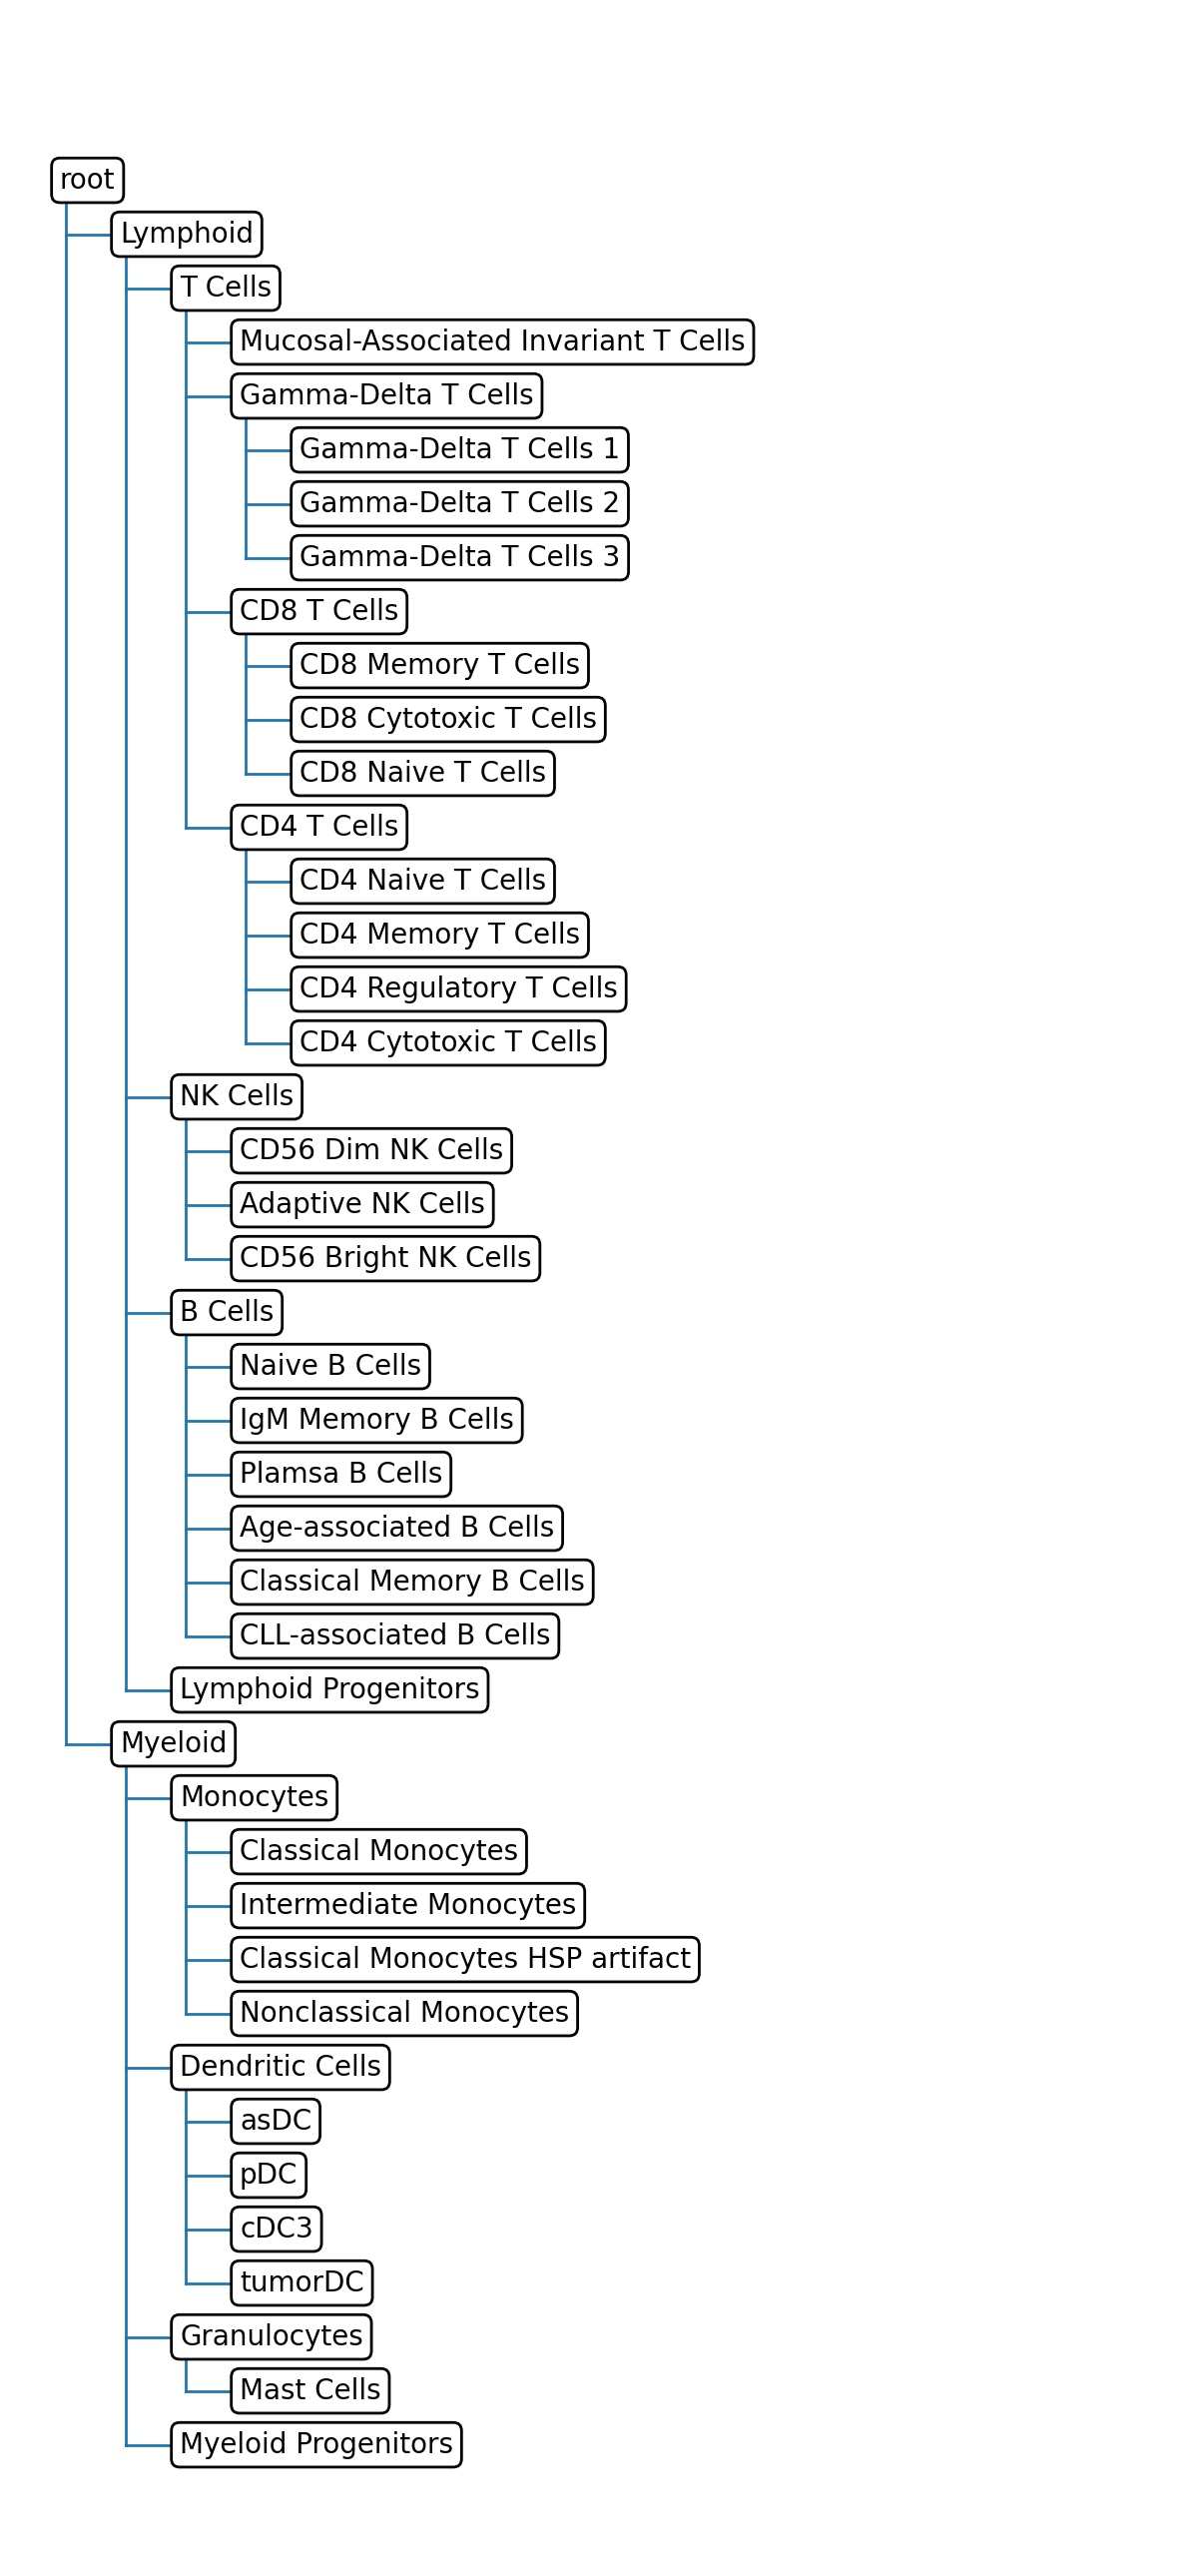

In [153]:
tree1 = utils.create_tree(dict2newick(tree, 'root'))
utils.print_tree(tree1)

In [34]:
adata.obsm['X_scvi'] = model.get_latent_representation(adata)

In [35]:
adata.obsm['X_mde'] = scvi.model.utils.mde(adata.obsm['X_scvi'])

In [36]:
for i, y in enumerate(adata.obsm['X_mde'].T):
    adata.obs[f'mde_{i + 1}'] = y

In [37]:
adata.obs['tree_label'] = adata.obs['cell_type_level_4']

In [38]:
# We are ignoring known labels for participant 51, so here we rename these

adata.obs.loc[adata.obs.query('`Participant IDs` == 51').index, 'tree_label'] = 'Unknown'

In [39]:
adata.obs['participant_ids'] = adata.obs['Participant IDs']

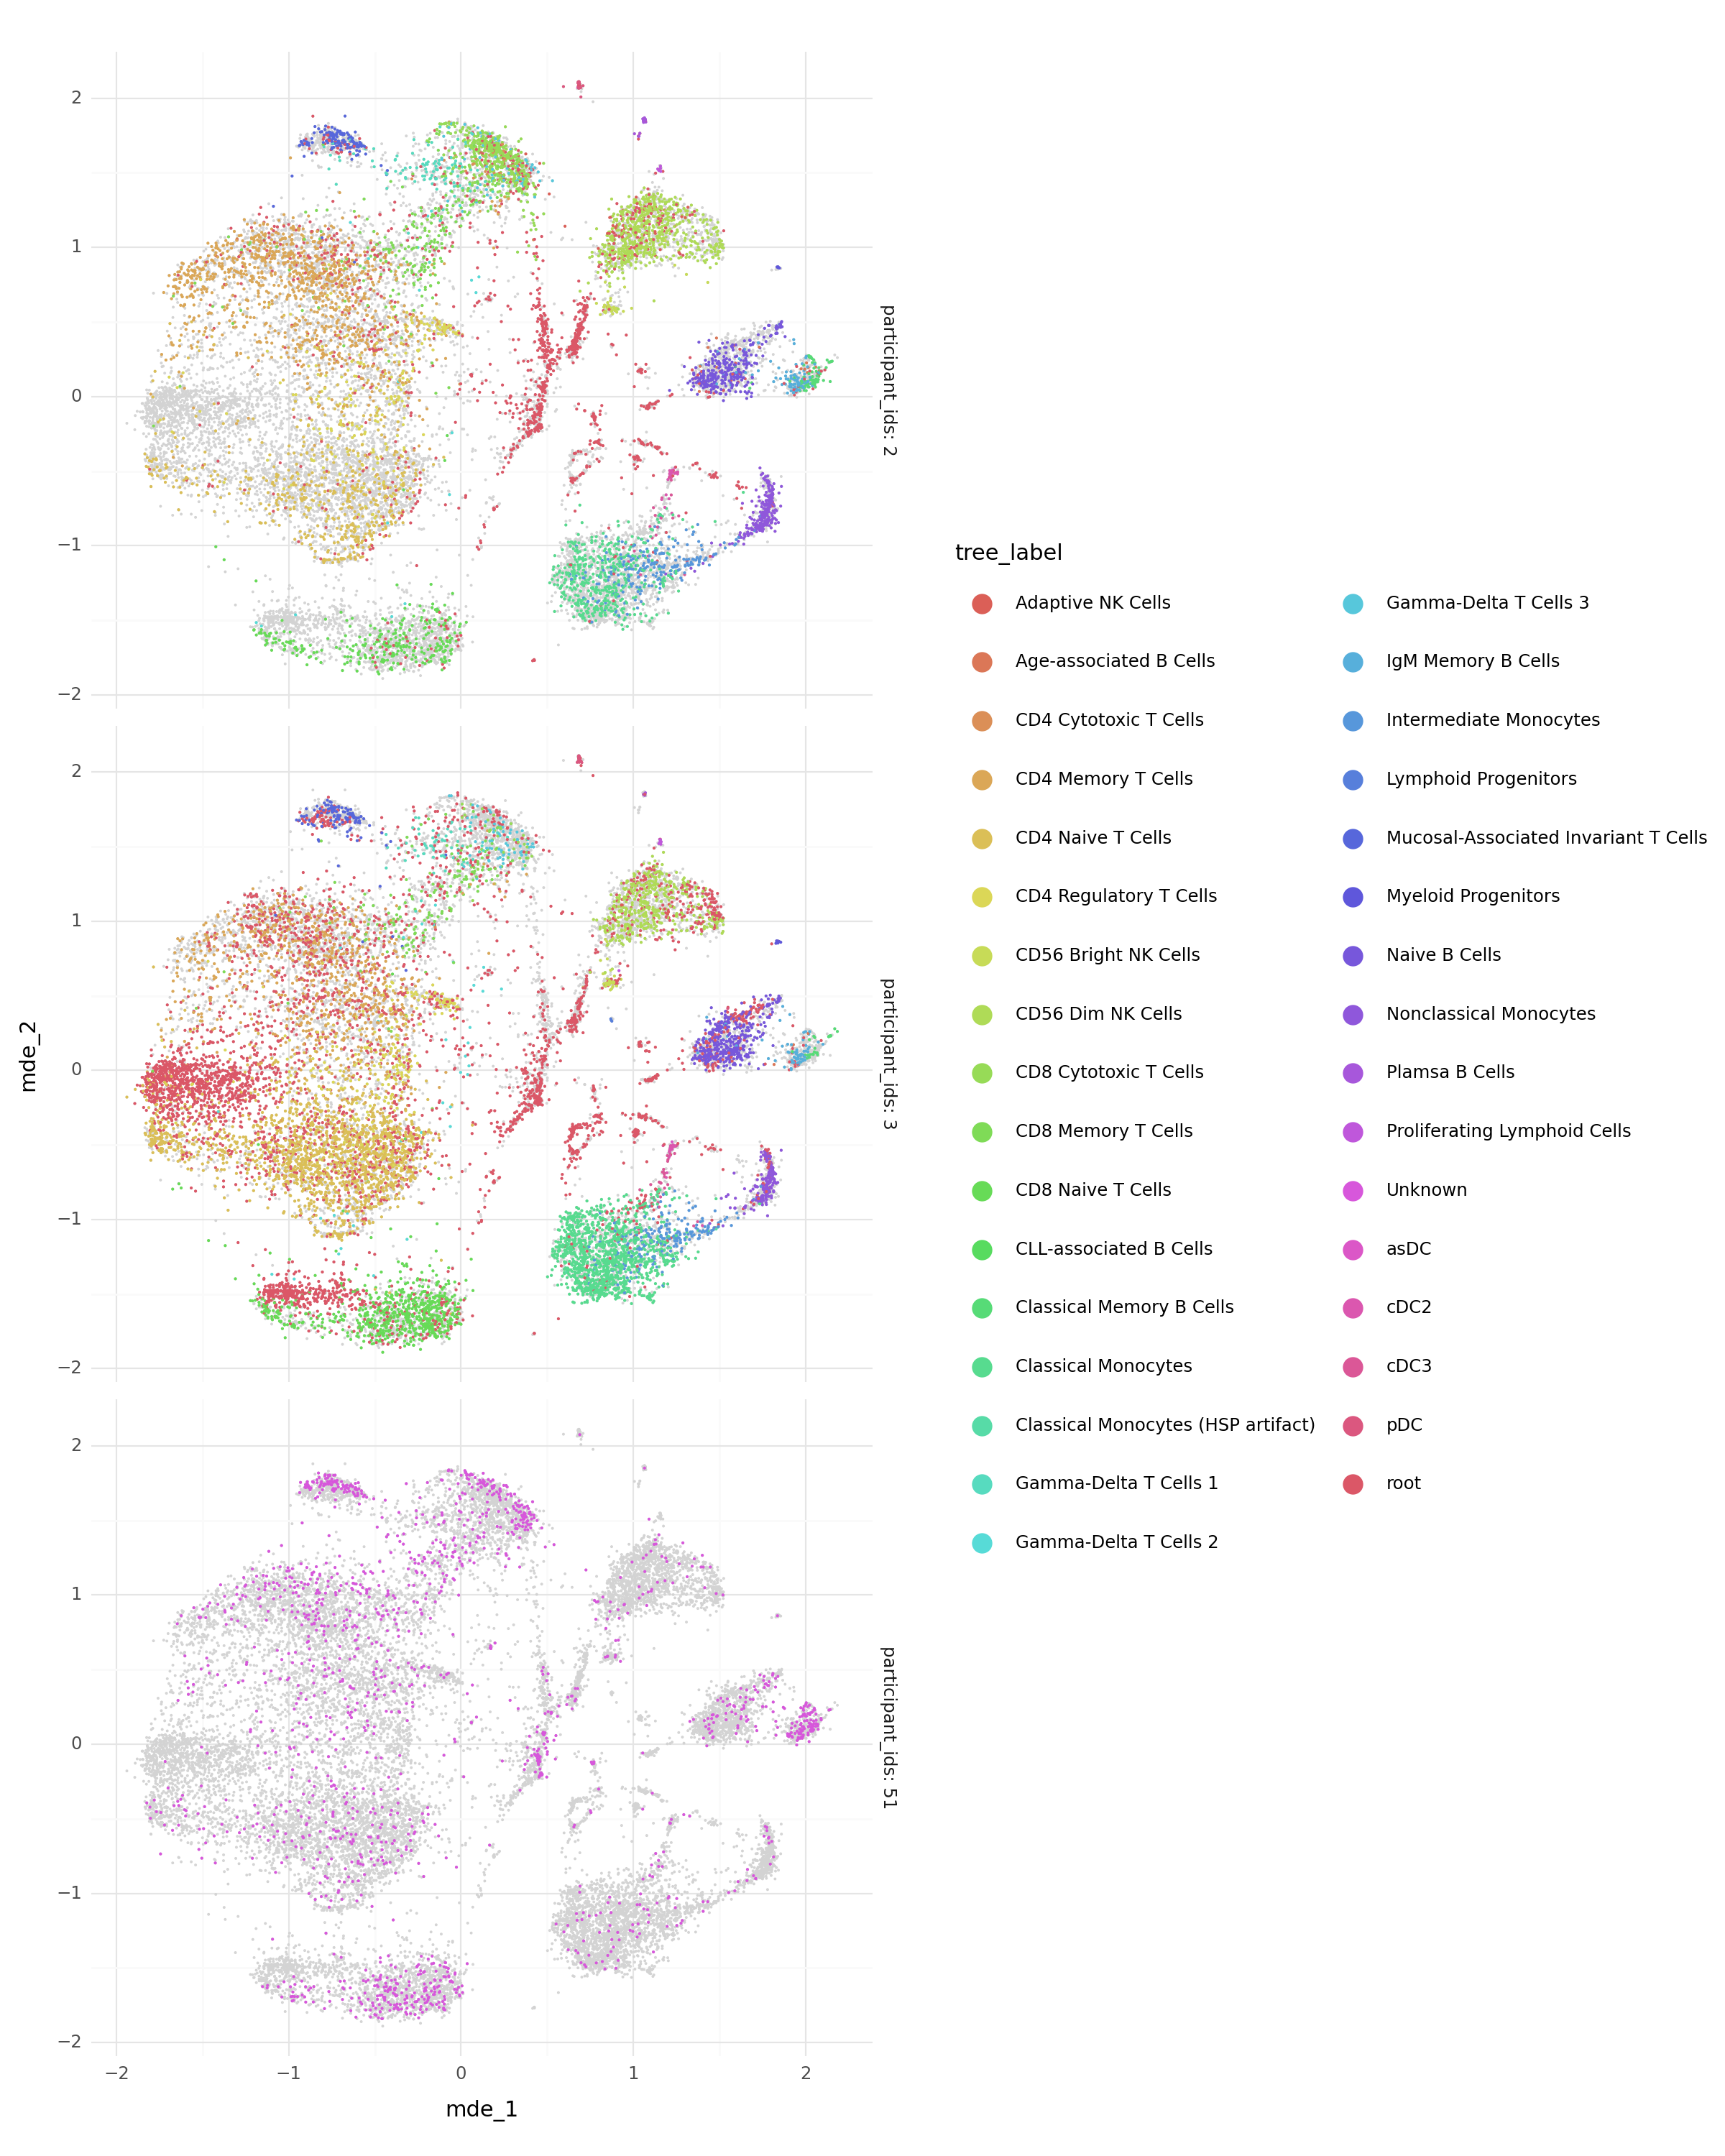

In [160]:
p.options.figure_size = 12, 15

tmp_ = adata.obs.sample(20_000)

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'tree_label'), tmp_)
    + p.geom_point(shape = '.', size = 0.1, color = 'lightgrey', data = tmp_.drop(['participant_ids'], axis = 1))
    + p.geom_point(shape = '.', size = 0.2)
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 10}))
    + p.facet_grid('participant_ids ~ .', labeller = 'label_both')
)

p_.save('fig3.png', dpi = 300)

print(p_)

In [41]:
adata_train = adata[adata.obs.query('participant_ids != 51').index].copy()

In [44]:
trained_tree = scHPL.train_tree(
    adata_train.obsm['X_scvi'],
    adata_train.obs['tree_label'],
    tree1,
    dimred = False,
    useRE = False
)

In [45]:
adata.obs['predicted_label'] = scHPL.predict_labels(adata.obsm['X_scvi'], trained_tree)

Epoch 26/50:  50%|██████████████████████████████████████████████████████████████                                                              | 25/50 [1:05:00<1:05:00, 156.03s/it, loss=7.29e+03, v_num=1]


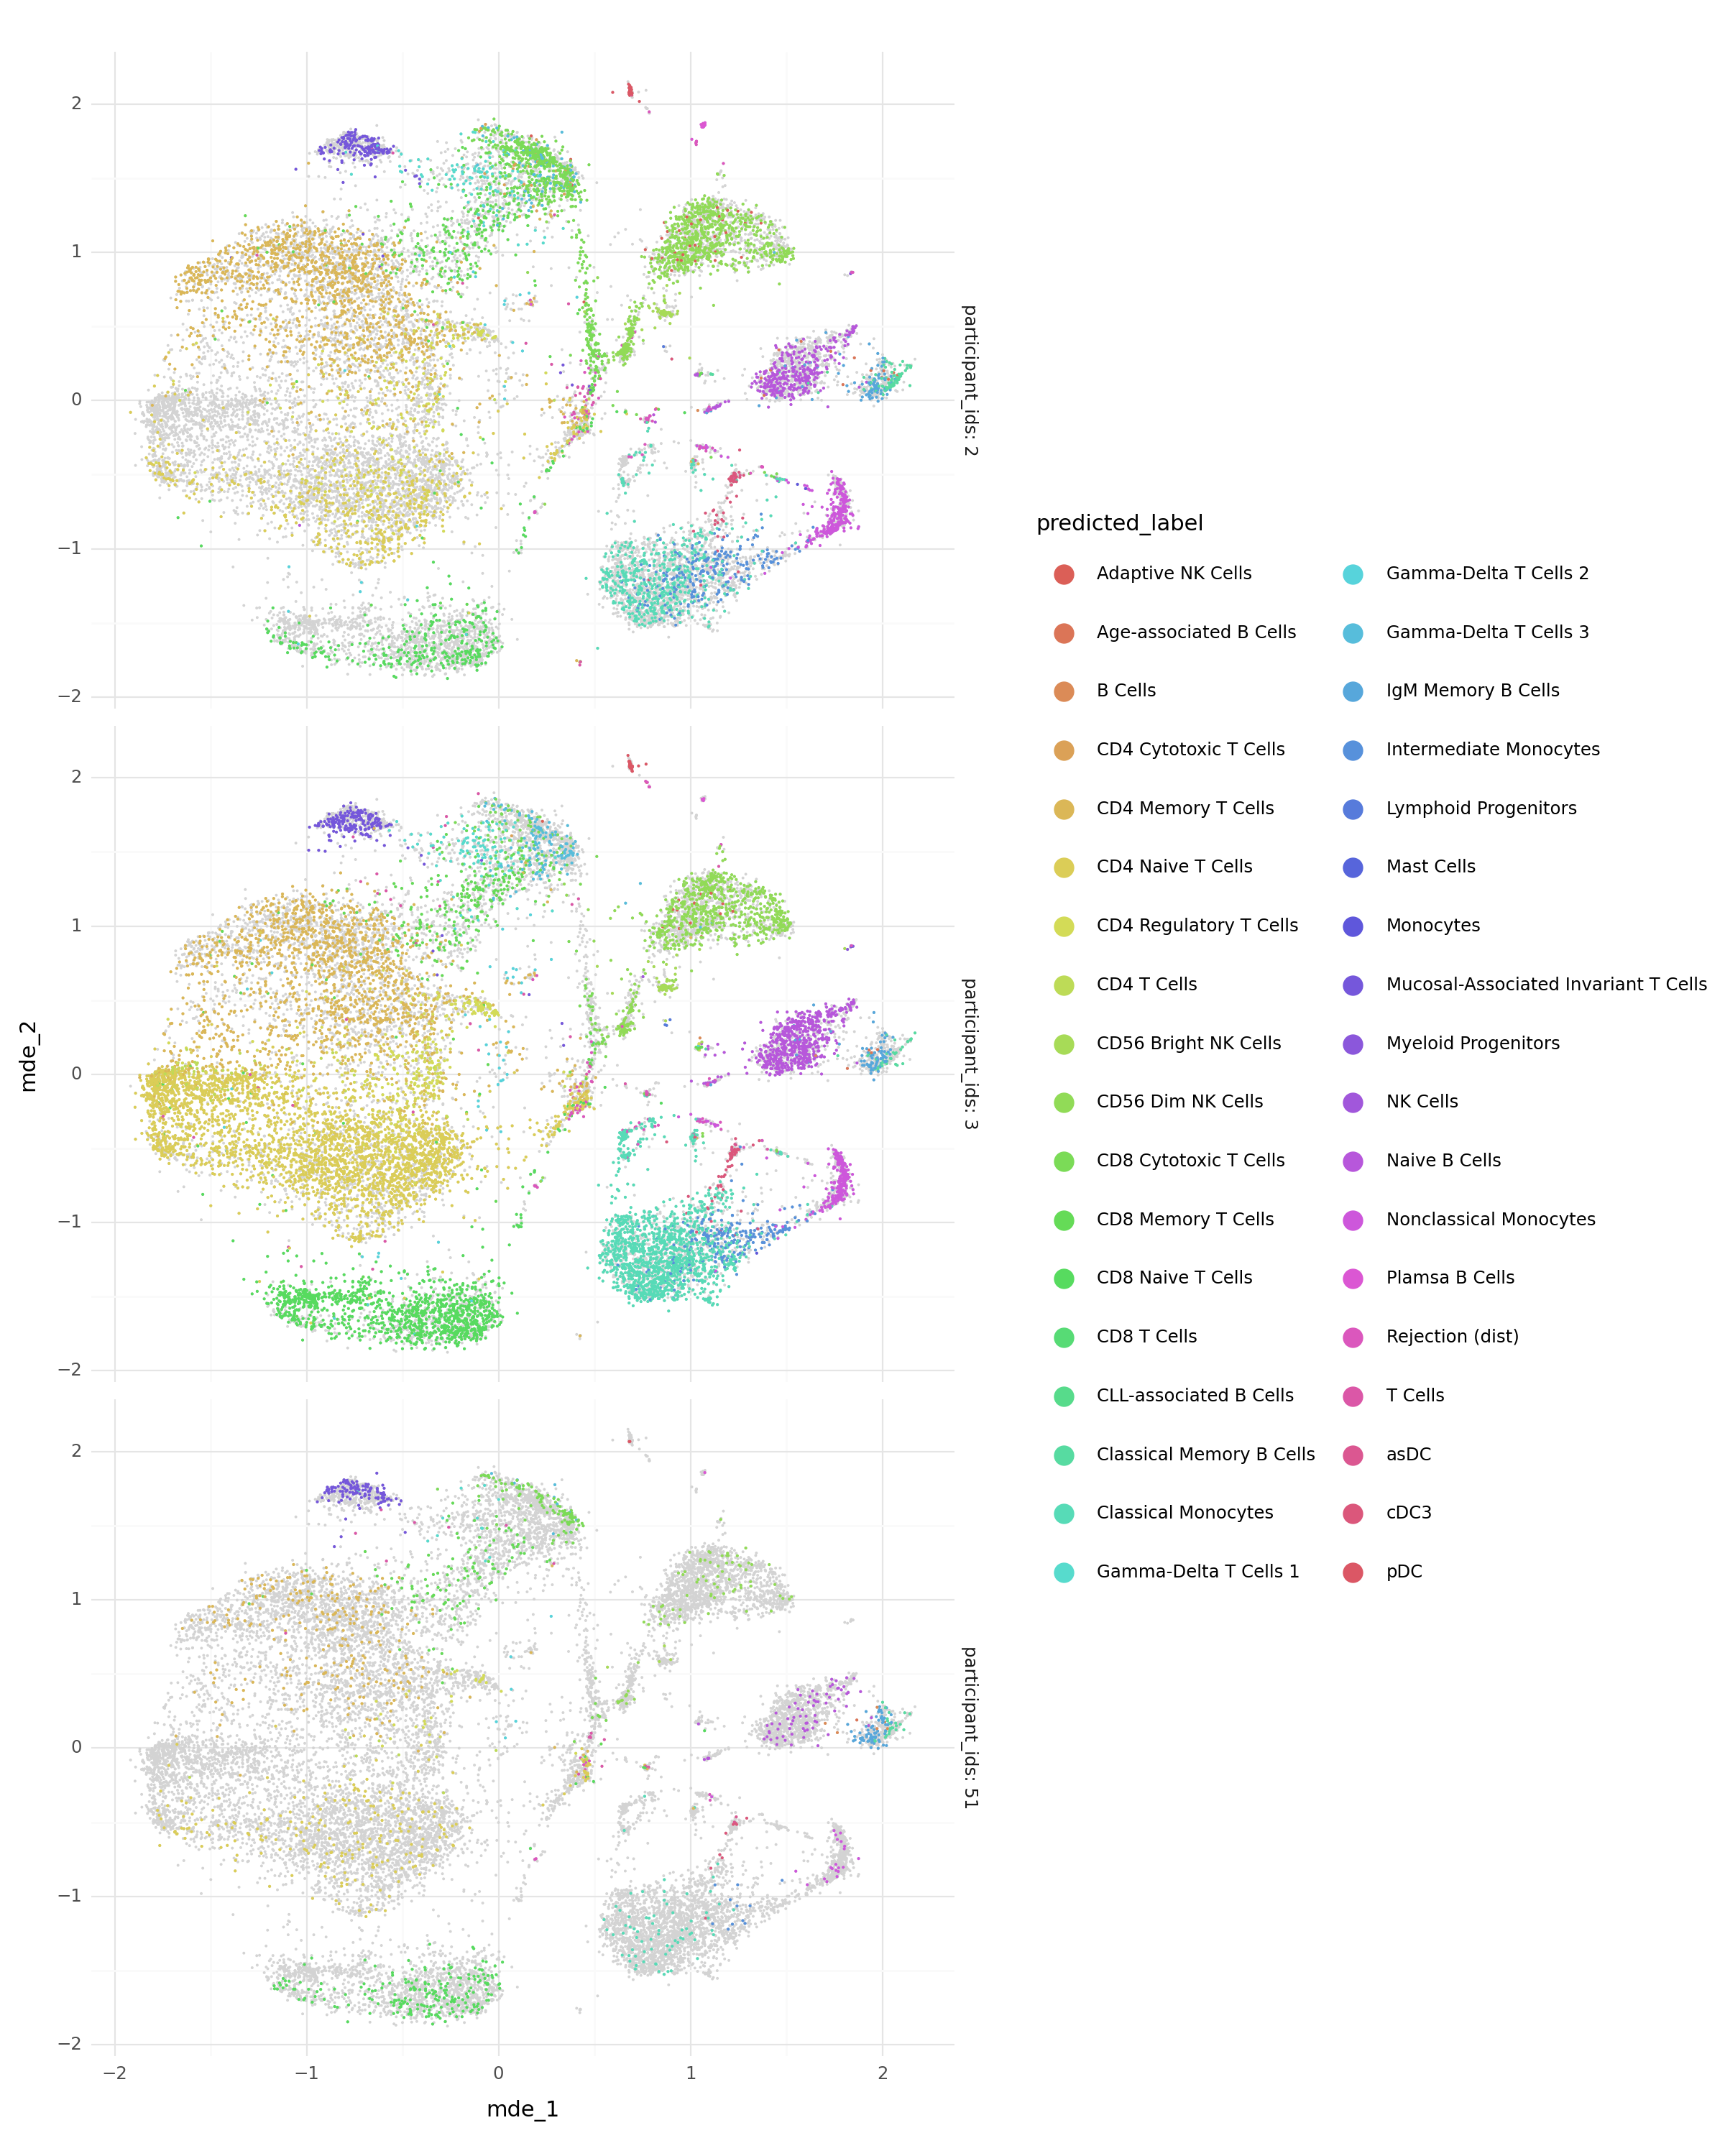

In [161]:
p.options.figure_size = 12, 15

tmp_ = adata.obs.sample(20_000)

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'predicted_label'), tmp_)
    + p.geom_point(shape = '.', size = 0.1, color = 'lightgrey', data = tmp_.drop(['participant_ids'], axis = 1))
    + p.geom_point(shape = '.', size = 0.2)
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 10}))
    + p.facet_grid('participant_ids ~ .', labeller = 'label_both')
)

p_.save('fig4.png', dpi = 300)

print(p_)

In [88]:
def get_depth_first_order(tree):

    label_order = []
    depth = 0 - 1

    def depth_first_order(node, label_order, depth):
        depth += 1
        label_order += [{'name': node.name[0], 'depth': depth}]

        for child in node.descendants:
            depth_first_order(child, label_order, depth)
            
        depth -= 1
            
    depth_first_order(tree[0], label_order, depth)
    
    return pd.DataFrame(label_order).reset_index().rename(columns = {'index': 'order'})

In [90]:
label_order = get_depth_first_order(tree1)

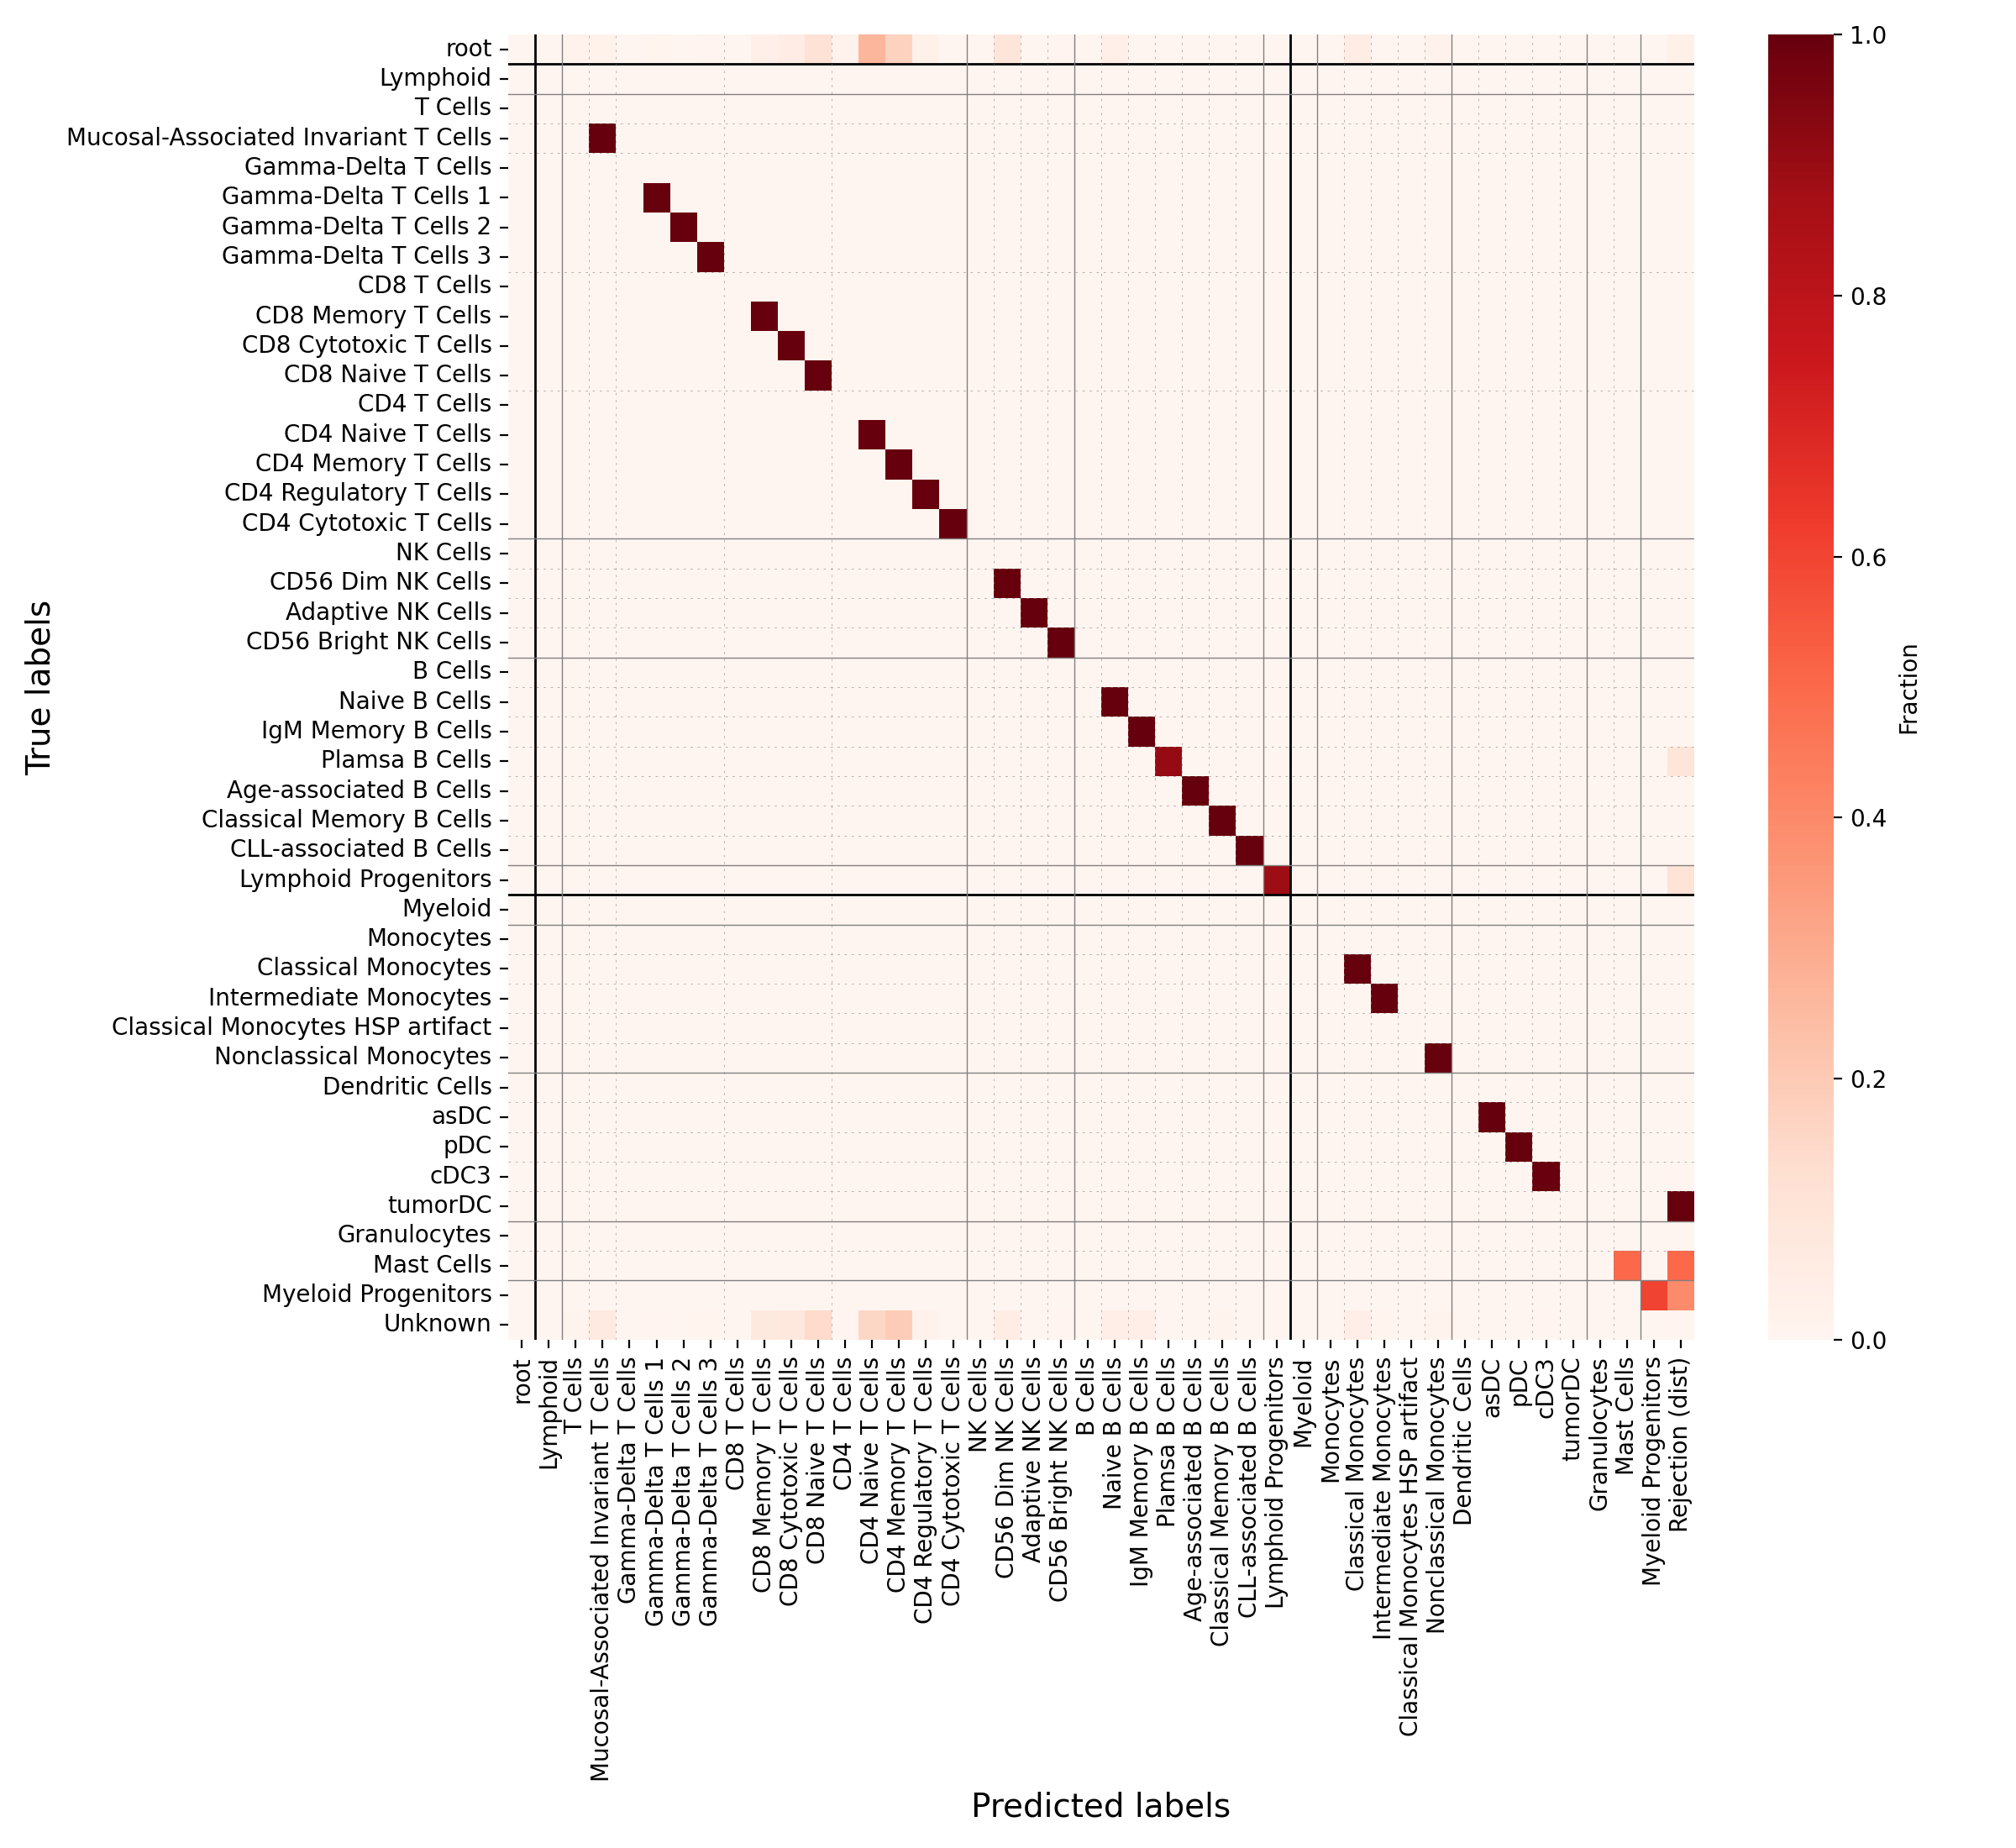

In [162]:
scHPL.evaluate.heatmap(
    adata.obs['tree_label'],
    adata.obs['predicted_label'],
    order_rows = label_order['name'].to_list() + ['Unknown'],
    order_cols = label_order['name'].to_list() + ['Rejection (dist)'],
    shape = (12, 11)
)

for i in label_order.query('depth == 1')['order'].values:
    plt.axhline(i, color = 'black', lw = 1)
    plt.axvline(i, color = 'black', lw = 1)
    
for i in label_order.query('depth == 2')['order'].values:
    plt.axhline(i, color = 'grey', lw = 0.5)
    plt.axvline(i, color = 'grey', lw = 0.5)
    
for i in label_order.query('depth == 3')['order'].values:
    plt.axhline(i, color = 'grey', lw = 0.2, ls = (0, (5, 10)))
    plt.axvline(i, color = 'grey', lw = 0.2, ls = (0, (5, 10)))
    
plt.tight_layout()

plt.savefig('fig5.png', dpi = 300)

In [48]:
for r in (
    adata.obs
    .query('participant_ids == 51')
    .groupby(['cell_type_level_4', 'predicted_label'], observed = True)
    .size()
    .reset_index()
    .iterrows()
):
    print(r[1].values)

['Adaptive NK Cells' 'CD56 Bright NK Cells' 1]
['Adaptive NK Cells' 'CD56 Dim NK Cells' 5]
['Adaptive NK Cells' 'CD8 Cytotoxic T Cells' 6]
['Adaptive NK Cells' 'Gamma-Delta T Cells 1' 1]
['Adaptive NK Cells' 'Gamma-Delta T Cells 3' 2]
['Age-associated B Cells' 'Age-associated B Cells' 2]
['Age-associated B Cells' 'B Cells' 2]
['Age-associated B Cells' 'Classical Memory B Cells' 1]
['Age-associated B Cells' 'Naive B Cells' 2]
['CD4 Cytotoxic T Cells' 'CD8 Cytotoxic T Cells' 1]
['CD4 Cytotoxic T Cells' 'Gamma-Delta T Cells 1' 1]
['CD4 Memory T Cells' 'CD4 Memory T Cells' 1171]
['CD4 Memory T Cells' 'CD4 Naive T Cells' 22]
['CD4 Memory T Cells' 'CD4 Regulatory T Cells' 9]
['CD4 Memory T Cells' 'CD4 T Cells' 10]
['CD4 Memory T Cells' 'CD8 Cytotoxic T Cells' 2]
['CD4 Memory T Cells' 'CD8 Memory T Cells' 20]
['CD4 Memory T Cells' 'Mucosal-Associated Invariant T Cells' 8]
['CD4 Memory T Cells' 'T Cells' 7]
['CD4 Naive T Cells' 'CD4 Memory T Cells' 32]
['CD4 Naive T Cells' 'CD4 Naive T Cells' 

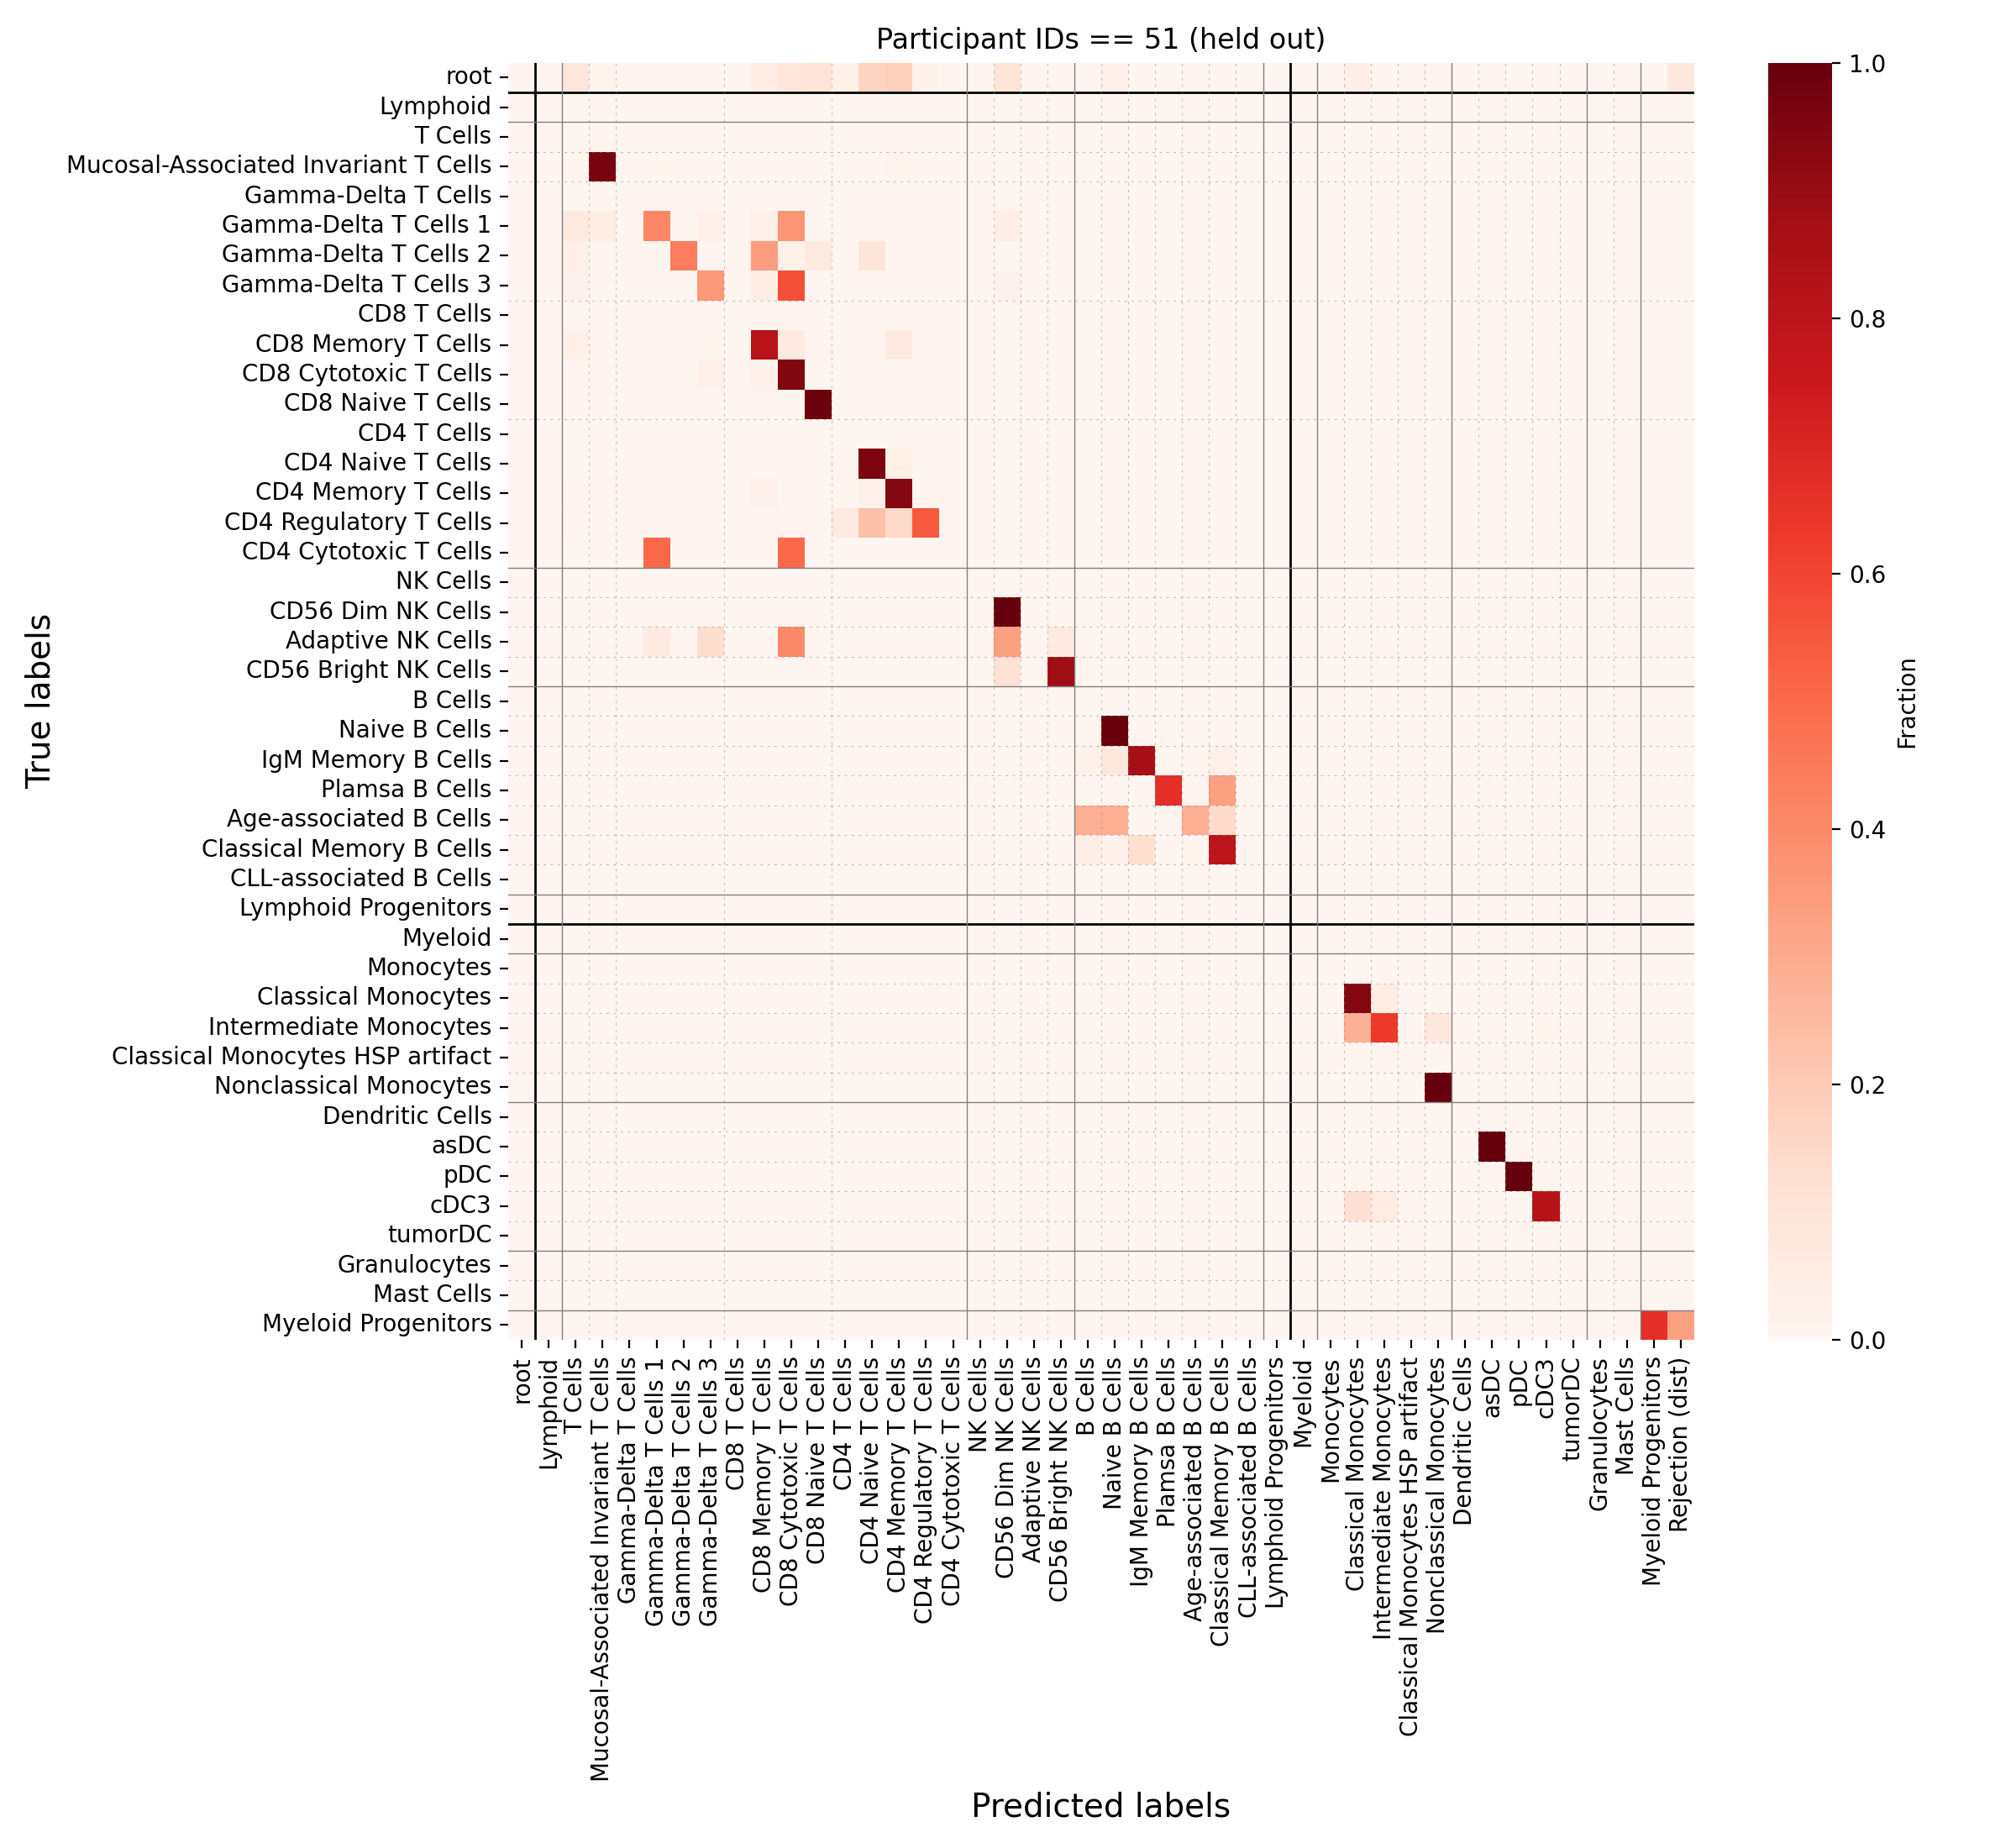

In [163]:
scHPL.evaluate.heatmap(
    adata.obs.query('participant_ids == 51')['cell_type_level_4'],
    adata.obs.query('participant_ids == 51')['predicted_label'],
    order_rows = label_order['name'].to_list(),
    order_cols = label_order['name'].to_list() + ['Rejection (dist)'],
    title = 'Participant IDs == 51 (held out)',
    shape = (12, 11)
);


for i in label_order.query('depth == 1')['order'].values:
    plt.axhline(i, color = 'black', lw = 1)
    plt.axvline(i, color = 'black', lw = 1)
    
for i in label_order.query('depth == 2')['order'].values:
    plt.axhline(i, color = 'grey', lw = 0.5)
    plt.axvline(i, color = 'grey', lw = 0.5)
    
for i in label_order.query('depth == 3')['order'].values:
    plt.axhline(i, color = 'grey', lw = 0.2, ls = (0, (5, 10)))
    plt.axvline(i, color = 'grey', lw = 0.2, ls = (0, (5, 10)))
    
plt.tight_layout()

plt.savefig('fig6.png', dpi = 300)